<a href="https://colab.research.google.com/github/CarOmodeo/practicos_pnl/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Desafio 3 - RNNs


## Alumno: Carolina Pérez Omodeo

### Consigna
 * Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
 * Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
 * Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
 * Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

 Utilizar otro dataset y poner en práctica la predicción de próxima palabra

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# Habilitar el uso de memoria virtual para evitar el OOM
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Datos
Se intentó utilizar el mismo libro del desafío anterior (Orgullo y Prejuicio de Jane Austen), pero debido a un error en la etapa de entrenamiento causado por problemas de falta de memoria, se optó por trabajar con un cuento corto. El cuento infantil seleccionado fue **"La Cenicienta"** de los Hermanos Grimm.

Sin embargo, al utilizar La Cenicienta, se llegó a la conclusión de que el modelo no estaba aprendiendo, a pesar de modificar los hiperparámetros, agregar capas al modelo, entre otras estrategias. Debido a esto, se decidió finalmente emplear una novela corta: lo suficientemente extensa para contar con un vocabulario amplio, pero lo suficientemente breve para evitar problemas de memoria. La novela seleccionada fue El Fantasma de Canterville de Oscar Wilde

In [282]:
from google.colab import files
uploaded = files.upload()

Saving El Fantasma de Canterville.txt to El Fantasma de Canterville.txt


In [283]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
df = pd.read_csv('El Fantasma de Canterville.txt', sep='/n', header=None, engine = 'python')
#df = pd.read_csv('la_cenicienta.txt', sep='/n', header=None, engine = 'python')
df.head()


,0
0,El Fantasma de Canterville
1,Oscar Wilde
2,Novela corta
3,I
4,"Cuando míster Hiram B. Otis, el ministro de Am..."


Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:

* Se consideran las palabras como términos.
* Se segmentará el texto del dataset y ses explorará la cantidad de términos presentes.

In [284]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 402


#### Paso 1: elegir tamaño del modelo

In [285]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences # se utilizará para padding


In [286]:
# cada oración la guardamos en una lista
text = list(df.loc[:,0])
text[:5]

['El Fantasma de Canterville',
 'Oscar Wilde',
 'Novela corta',
 'I',
 'Cuando míster Hiram B. Otis, el ministro de América, compró Canterville-Chase, todo el mundo le dijo que cometía una gran necedad, porque la finca estaba embrujada.']

In [287]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]
text[0]

'El Fantasma de Canterville'

In [288]:
segmented_sentences[:3]

[['el', 'fantasma', 'de', 'canterville'],
 ['oscar', 'wilde'],
 ['novela', 'corta']]

In [289]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]


(array([130., 152.,  66.,  31.,  11.,   5.,   1.,   0.,   3.,   1.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([  1. ,  16.5,  32. ,  47.5,  63. ,  78.5,  94. , 109.5, 125. ,
        140.5, 156. , 171.5, 187. , 202.5, 218. , 233.5, 249. , 264.5,
        280. , 295.5, 311. ]),
 <BarContainer object of 20 artists>)

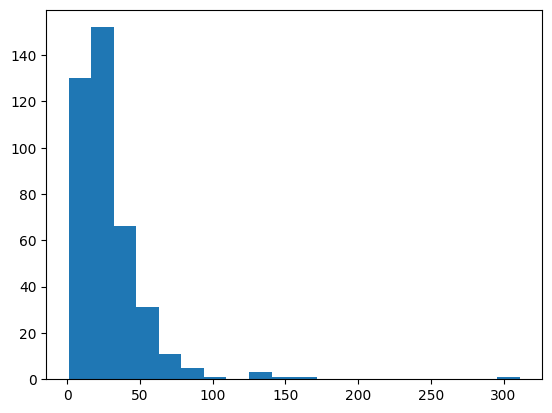

In [290]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

A partir del análisis del histograma, elegimos el criterio del percentil para la selección del máximo tamaño de contexto. Elegir el percentil 90 como criterio garantiza que el 90% de las oraciones del texto se procesen completamente sin truncamientos, mientras que solo el 10% más largo se verá afectado. Este enfoque equilibra la preservación de la información textual y la eficiencia computacional, ya que evita incluir secuencias excesivamente largas que podrían introducir ruido o requerir un relleno innecesario (padding). Además, este criterio es estadísticamente robusto, ya que considera la distribución general de las longitudes, adaptándose a la estructura del conjunto de datos sin depender de decisiones arbitrarias.


In [291]:
# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

print(f'max_context_size: {max_context_size}')

max_context_size: 51


### Paso 2: Tokenización

In [292]:
# Definir una función para eliminar el "—" de los dialogos.
def clean_word(word):
    return word.replace("—", "")

# Aplicar la función de limpieza a las palabras antes de tokenizar
cleaned_sentences = [[clean_word(word) for word in sentence] for sentence in segmented_sentences]
#cleaned_sentences = segmented_sentences

In [293]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(cleaned_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(cleaned_sentences)

In [294]:
tokenized_sentences[0]

[5, 26, 1, 30]

In [295]:
cleaned_sentences[0]


['el', 'fantasma', 'de', 'canterville']

### Paso 3: Organizarción y estructurado del dataset

In [296]:
# Vamos a quedarnos con un conjunto de validación que utilizaremos
# para medir la calidad de la generación de secuencias con la métrica de Perplejidad.
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)


In [297]:
# Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo,
# para generarnos más secuencias de entrenamiento.
# Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [298]:
len(tok_sent)

1326

In [299]:
# Ahora aumentamos los datos aprovechando que de una secuencia grande
# se pueden generar varias más pequeñas:

tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [300]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [301]:
train_seqs.shape

(59179, 52)

In [302]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [303]:
y.shape

(59179, 51)

In [304]:
# Palabras del vocabulario
tok.index_word

{1: 'de',
 2: 'la',
 3: 'y',
 4: 'que',
 5: 'el',
 6: 'en',
 7: 'a',
 8: 'se',
 9: 'una',
 10: 'un',
 11: 'su',
 12: 'no',
 13: 'los',
 14: 'por',
 15: 'con',
 16: 'las',
 17: 'del',
 18: 'al',
 19: 'sus',
 20: 'le',
 21: 'lo',
 22: 'para',
 23: 'sobre',
 24: 'otis',
 25: 'pero',
 26: 'fantasma',
 27: 'virginia',
 28: 'más',
 29: 'era',
 30: 'canterville',
 31: 'como',
 32: 'usted',
 33: 'había',
 34: 'cuando',
 35: 'es',
 36: 'todo',
 37: 'después',
 38: 'mistress',
 39: 'míster',
 40: 'dijo',
 41: 'gran',
 42: 'familia',
 43: 'muy',
 44: 'estaba',
 45: 'lord',
 46: 'me',
 47: 'vez',
 48: 'fue',
 49: 'noche',
 50: 'gemelos',
 51: 'ministro',
 52: 'casa',
 53: 'ya',
 54: 'ojos',
 55: 'él',
 56: 'toda',
 57: 'hacer',
 58: 'hasta',
 59: 'dos',
 60: 'tan',
 61: 'sin',
 62: 'tenía',
 63: 'sangre',
 64: 'ha',
 65: 'hizo',
 66: 'cabeza',
 67: 'día',
 68: 'aquella',
 69: 'todos',
 70: 'mi',
 71: 'o',
 72: 'eso',
 73: 'mientras',
 74: 'tiempo',
 75: 'nada',
 76: 'unos',
 77: 'washington',
 78:

In [305]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

3287

In [306]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'de': 1, 'la': 2, 'y': 3, 'que': 4, 'el': 5, 'en': 6, 'a': 7, 'se': 8, 'una': 9, 'un': 10, 'su': 11, 'no': 12, 'los': 13, 'por': 14, 'con': 15, 'las': 16, 'del': 17, 'al': 18, 'sus': 19, 'le': 20, 'lo': 21, 'para': 22, 'sobre': 23, 'otis': 24, 'pero': 25, 'fantasma': 26, 'virginia': 27, 'más': 28, 'era': 29, 'canterville': 30, 'como': 31, 'usted': 32, 'había': 33, 'cuando': 34, 'es': 35, 'todo': 36, 'después': 37, 'mistress': 38, 'míster': 39, 'dijo': 40, 'gran': 41, 'familia': 42, 'muy': 43, 'estaba': 44, 'lord': 45, 'me': 46, 'vez': 47, 'fue': 48, 'noche': 49, 'gemelos': 50, 'ministro': 51, 'casa': 52, 'ya': 53, 'ojos': 54, 'él': 55, 'toda': 56, 'hacer': 57, 'hasta': 58, 'dos': 59, 'tan': 60, 'sin': 61, 'tenía': 62, 'sangre': 63, 'ha': 64, 'hizo': 65, 'cabeza': 66, 'día': 67, 'aquella': 68, 'todos': 69, 'mi': 70, 'o': 71, 'eso': 72, 'mientras': 73, 'tiempo': 74, 'nada': 75, 'unos': 76, 'washington': 77, 'mancha': 78, 'habitación': 79, 'entonces': 80, 'desde': 81, 'nunca': 82, 'así':

In [307]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'el': 189, 'fantasma': 49, 'canterville': 41, 'de': 282, 'wilde': 1, 'oscar': 1, 'corta': 1, 'novela': 1, 'i': 1, 'la': 223, 'ministro': 20, 'chase': 5, 'que': 190, 'necedad': 1, 'embrujada': 1, 'míster': 28, 'gran': 25, 'américa': 6, 'mundo': 9, 'finca': 2, 'b': 1, 'cometía': 1, 'compró': 1, 'dijo': 27, 'le': 57, 'hiram': 2, 'estaba': 23, 'cuando': 37, 'todo': 28, 'otis': 60, 'una': 119, 'porque': 9, 'a': 180, 'hasta': 18, 'las': 81, 'se': 144, 'en': 176, 'llegaron': 3, 'mismo': 9, 'escrupulosa': 1, 'como': 33, 'lord': 22, 'participárselo': 1, 'deber': 4, 'hombre': 3, 'más': 44, 'honradez': 1, 'creyó': 2, 'discutir': 1, 'condiciones': 2, 'así': 12, 'esqueleto': 5, 'un': 113, 'abuela': 1, 'bolton': 1, 'varios': 6, 'miembros': 1, 'sitio': 8, 'ya': 18, 'lady': 7, 'nunca': 12, 'quedarse': 1, 'sido': 7, 'vistiéndose': 1, 'creo': 6, 'familia': 24, 'después': 29, 'desde': 11, 'sueño': 2, 'doncellas': 2, 'motivado': 1, 'augusto': 2, 'biblioteca': 11, 'cenar': 1, 'a

### Paso 4: Definición del modelo

In [308]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True, dropout=0.3))

model.add(LSTM(100, return_sequences=True, dropout=0.2))
#model.add(Dropout(0.2))
#model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)             │ (None, None, 50)            │         164,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_27 (LSTM)                       │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_28 (LSTM)                       │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, None, 3288)          │         332,088 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 637,288 (2.43 MB)

 Trainable params: 637,288 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

In [309]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True



### Paso 5: Entrenamiento

In [310]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=128)


Epoch 1/20
461/463 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 4.1909
 mean perplexity: 241067.83734004383 

Saved new model!
463/463 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 4.1860
Epoch 2/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 3.0193
 mean perplexity: 167453.29138341564 

Saved new model!
463/463 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 3.0193
Epoch 3/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.8915
 mean perplexity: 170980.4695975374 

463/463 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - loss: 2.8913
Epoch 4/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.6303
 mean perplexity: 153562.09639552774 

Saved new model!
463/463 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - loss: 2.6302
Epoch 5/20
461/463 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3826
 mean perplexity: 122726.8806575989 

Saved new model!
463/463 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 2.3823
Epoch 6/20
463/463 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.1930
 mean perplexity: 135034.50802295093 

46

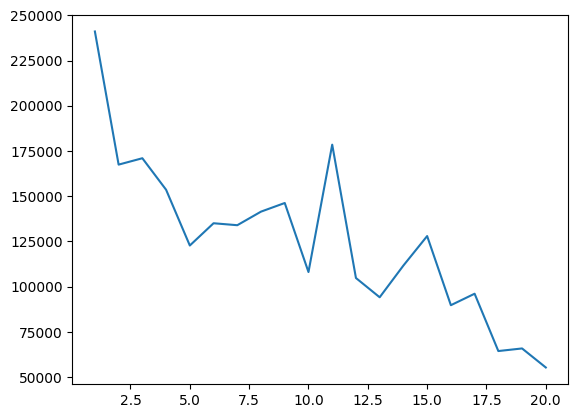

In [311]:
import matplotlib.pyplot as plt
import seaborn as sns

# Podemos graficar la evolución de la perplejidad con las épocas.
# Recordar que el valor de perplejidad del modelo trivial es el tamaño del vocabulario.
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [312]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')

Del entrenamiento del modelo, podemos ver que:

* **Loss decreciente:** El valor de loss disminuye a lo largo de las épocas, lo que indica que el modelo está aprendiendo a predecir la siguiente palabra en la secuencia con mayor precisión.
* **Perplejidad decreciente:** La perplejidad también disminuye en general.

**Guardado del modelo:**

El callback PplCallback guardó el modelo en las épocas 12, 13, 16, 18, y 20. Esto se debe a que la perplejidad seguía mejorando en esos puntos.

### Paso 6: Predicción de la próxima palabra

#### Paso 6.1: Generación de secuencias

In [313]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [320]:
input_text='el fantasma'

generate_seq(model, tok, input_text, max_length=max_context_size, n_words=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


'el fantasma ha sido visto por varios miembros de mi familia que'

El modelo de predicción de secuencias basado en LSTM muestra un desempeño prometedor al generar texto coherente y relevante dentro del contexto del corpus El fantasma de Canterville. En este caso, a partir de la frase inicial **"el fantasma"**, el modelo produce una continuación razonable: **"ha sido visto por varios miembros de mi familia que"**. Esto indica que el modelo ha aprendido relaciones semánticas y patrones sintácticos del texto de entrenamiento.

#### Paso 6.2: Beam search y muestreo aleatorio

In [321]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [322]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [326]:
# predicción con beam search.
# Se pueden cambiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas = beam_search(model,num_beams=10,num_words=6,input="el fantasma",temp=1,mode='sto')

In [327]:
# tenemos `num_beams` salidas ordenadas de mayor a menor likelihood
salidas.shape

(10, 57)

In [328]:
# veamos las salidas
decode(salidas[0])

['el fantasma ha sido visto por varios miembros']

El uso de Beam Search con muestreo aleatorio permitió generar texto coherente y diverso, manteniendo relevancia contextual. La frase generada, "el fantasma ha sido visto por varios miembros", demuestra que el modelo puede explorar alternativas probabilísticas sin perder fluidez.

### Conclusión

El entrenamiento fue exitoso, demostrando que el modelo basado en LSTM logró aprender patrones semánticos y sintácticos del corpus, generando texto coherente y contextual. Las estrategias de predicción directa y Beam Search mostraron ser efectivas para complementar la capacidad del modelo, permitiendo tanto continuidad lógica como diversidad en las secuencias generadas. Esto evidencia el potencial de las LSTM combinadas con técnicas avanzadas de generación para resolver tareas de predicción de texto de manera eficiente.